### Udacity Data Science Nanodegree
### Project 1: Writing a Data Scientist Blog Post
---

# Part II - London Airbnb Data - EDA
## by Juanita Smith


- [Introduction](#intro)
- [Data gathering](#getdata)
- [Feature Engineering](#featureeng)
- [Step 1: Univariate Exploratoin](#univariate)
- [Step 2: Bivariate Exploratoin](#bivariate)
- [Step 3: Multivariate Exploratoin](#multivariate)
- [Conclusions](#conclusions)
- [References](#references)
- [Submission](#submission)

<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

### Context:
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in London, United Kingdom.


### Dictionary:

In Part I, Airbnb London listing data was cleaned, and only a subset of the available features was selected to support analysis of below questions.

**Recap of the origin of data:**

Airbnb activity is included for **London** and is a snapshot of booking availability on 8 June 2023

Data was downloaded from Airbnb [here](http://insideairbnb.com/get-the-data/). Scroll down to London section. 

To support this analysis, only listings and calendar data was needed.

Metadata are available [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596)

## Are you like me going the Taylor Swift concert in London next June and looking for the best place to stay ?

This project will focus on answering questions below, whilst this notebook focus on questions 2 and 3 in blue

#### 1) Are some hosts running a business, and if so, what is the impact on price ?
> - Can we identify businesses by the duration of rentals ? Are businesses focusing on short or long term term rentals? What impact have rental duration have on price ?
> - Are some hosts running a business with multiple listings ? If so, how does this affect the price ?

<span style="color:blue; font-size:20px; line-height:20px; font-family: Calibri;">2) Host Analysis: How does **host excellence** influence price ?</span>
> - Super hosts seems to describe their properties better, how does this effect price and availability ?


<span style="color:blue; font-size:20px; line-height:20px; font-family: Calibri;">3) What effect does **star ratings** have on rental price ?</span>
> - Would a 5-star vs 3-star listing in the same location cost more ?


#### 4) Predict average daily listing price
> - Knowing the impact of host excellence and star ratings above, could we make an accurate average daily price prediction ?


## 2) Host Analysis: How does **host excellence** influence price ?

### Main feature(s) of interest

> I would expect commercial rentals to be lower in price per day, with a minimum rental period for longer periods 3 months and more

We are looking to classify rentals between individual or commercial rentals.

Main features of interest to help detect commercial rentals:
- What is the price impact on superhosts
- Which other features impact price ?
- Which correlations exists ?

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import os
import missingno as msno
from datetime import datetime

# fuzzy compare neighborhood strings
from fuzzywuzzy import fuzz

# Entity recognition: is the host a person or business ?
import stanza

# from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer

# clear the garbage to free memory as we are working with huge datasets
import gc 

# import warnings
# warnings.filterwarnings("ignore")

# Import custom modules
# from project1_blog.src.utils import reduce_mem_usage, create_folder, entity_recognision
import project1_blog.src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# # use high resolution if this project is run on an apple device
# %config InlineBackend.figure_format='retina'

# Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# stop scientific notation on graphs
# pd.options.display.float_format = '{:.0f}'.format

import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS
import contextily as ctx

gpd.options.display_precision = 15

In [2]:
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_SUB1, BASE_COLOR_SUB2, SYMBOLS = vs.set_plot_defaults()

In [3]:
# default file paths
FILE_PATH_RAW = '../data/raw/'
# FILE_NAME_CLEAN = '../data/clean/listing_clean.pkl'
FILE_NAME_ENHANCED = '../data/clean/listing_enhanced.pkl'

<a id='getdata'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Gather Data</span>

In [4]:
# filename = FILE_PATH_RAW + 'listings/london/listings_060623.csv'
# listings = pd.read_csv(filename)
# listings.head()

In [5]:
# load the enhanced listing file 
listings = pd.read_pickle(FILE_NAME_ENHANCED)

In [6]:
cols = ['host_id', 'listing_id', 'latitude', 'longitude', 'neighbourhood_cleansed', 'price_mean']
# listings = listings[listings['neighbourhood_cleansed'] == 'Westminster'][cols].copy()
listings_geo = listings[cols].copy()
listings_geo.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)
listings_geo.head()

,host_id,listing_id,latitude,longitude,neighbourhood,price_mean
0,757377,157714,51.48974,-0.22208,Hammersmith and Fulham,70
1,54730,13913,51.56861,-0.11270,Islington,79
2,60302,15400,51.48780,-0.16813,Kensington and Chelsea,107
3,1573870,306333,51.52748,-0.08172,Hackney,198
4,766056,159736,51.46788,-0.09993,Lambeth,62


In [7]:
listings_geo.shape

(68923, 6)

In [8]:
listings_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68923 entries, 0 to 69184
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   host_id        68923 non-null  int64  
 1   listing_id     68923 non-null  int64  
 2   latitude       68923 non-null  float64
 3   longitude      68923 non-null  float64
 4   neighbourhood  68923 non-null  object 
 5   price_mean     68923 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 3.7+ MB


In [9]:
listings_geo.dropna(inplace=True)
listings_geo.shape

(68923, 6)

In [10]:
# get neighborhood shapes
crs_4326 = CRS("WGS84")
neighbourhood = gpd.read_file('../data/raw/neighbourhood_geojson/london/neighbourhoods_060623.geojson', crs=crs_4326)
neighbourhood.head()

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,None,MULTIPOLYGON (((-0.330679000000000 51.32901100...
1,Croydon,None,MULTIPOLYGON (((-0.064021000000000 51.31863800...
2,Bromley,None,MULTIPOLYGON (((0.012131000000000 51.299599000...
3,Hounslow,None,MULTIPOLYGON (((-0.244562000000000 51.48870200...
4,Ealing,None,MULTIPOLYGON (((-0.411833000000000 51.53408400...


In [11]:
# calculate average price per neighborhood
neigborhood_price = listings_geo.groupby('neighbourhood', as_index=False)['price_mean'].mean()

In [12]:
neighbourhood = neighbourhood.merge(neigborhood_price, on='neighbourhood')
neighbourhood.head()

,neighbourhood,neighbourhood_group,geometry,price_mean
0,Kingston upon Thames,None,MULTIPOLYGON (((-0.330679000000000 51.32901100...,137.494424
1,Croydon,None,MULTIPOLYGON (((-0.064021000000000 51.31863800...,102.271394
2,Bromley,None,MULTIPOLYGON (((0.012131000000000 51.299599000...,117.785948
3,Hounslow,None,MULTIPOLYGON (((-0.244562000000000 51.48870200...,175.601031
4,Ealing,None,MULTIPOLYGON (((-0.411833000000000 51.53408400...,132.559464


In [13]:
# make geometry field
listings_geo['geometry'] = listings_geo.apply(lambda x: Point((x.longitude, x.latitude)), axis=1)
type(listings_geo)

pandas.core.frame.DataFrame

In [14]:
listings_geo = gpd.GeoDataFrame(listings_geo, crs=crs_4326, geometry=listings_geo.geometry)
type(listings_geo)

geopandas.geodataframe.GeoDataFrame

In [15]:
# # Look at listings
# # # Check crs
# listings_geo = listings_geo.to_crs(neighbourhood.crs)

# listings_geo.plot(marker='*', color='green', markersize=5);

# # Now you can overlay over the outlines

In [16]:
# from folium import plugins
# import folium
# locs_190709_map = folium.Map(location=[50.1, 0], zoom_start = 13, tiles='cartodbpositron')

# feature_ea = folium.FeatureGroup(name='Entire home/apt')
# feature_pr = folium.FeatureGroup(name='Private room')
# feature_sr = folium.FeatureGroup(name='Shared room')

# for i, v in listings_geo.iterrows():
#     popup = """
#     Location id : <b>%s</b><br>
#     Host name : <b>%s</b><br>
#     Room type : <b>%s</b><br>
#     Neighbourhood : <b>%s</b><br>
#     Price : <b>%d</b><br>
#     Minimum nights : <b>%d</b><br>
#     """ % (v['listing_id'], v['host_name'], v['room_type'], v['neighbourhood_cleansed'], v['price'], v['minimum_minimum_nights'])
    
#     if v['room_type'] == 'Entire home/apt':
#         folium.CircleMarker(location=[v['latitude'], v['longitude']],
#                             radius=1,
#                             tooltip=popup,
#                             color='#FFBA00',
#                             fill_color='#FFBA00',
#                             fill=True).add_to(feature_ea)
#     elif v['room_type'] == 'Private room':
#         folium.CircleMarker(location=[v['latitude'], v['longitude']],
#                             radius=1,
#                             tooltip=popup,
#                             color='#087FBF',
#                             fill_color='#087FBF',
#                             fill=True).add_to(feature_pr)
#     elif v['room_type'] == 'Shared room':
#         folium.CircleMarker(location=[v['latitude'], v['longitude']],
#                             radius=1,
#                             tooltip=popup,
#                             color='#FF0700',
#                             fill_color='#FF0700',
#                             fill=True).add_to(feature_sr)

# feature_ea.add_to(locs_190709_map)
# feature_pr.add_to(locs_190709_map)
# feature_sr.add_to(locs_190709_map)
# folium.LayerControl(collapsed=False).add_to(locs_190709_map)
# locs_190709_map.save('locations_190709_v1.html')

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
# add marker for taylor swift concert
lat =[51.556028]
long = [-0.2821926]
geometry = [Point(xy) for xy in zip(long,lat)]

ts_df = gpd.GeoDataFrame(geometry = geometry, crs=crs_4326)

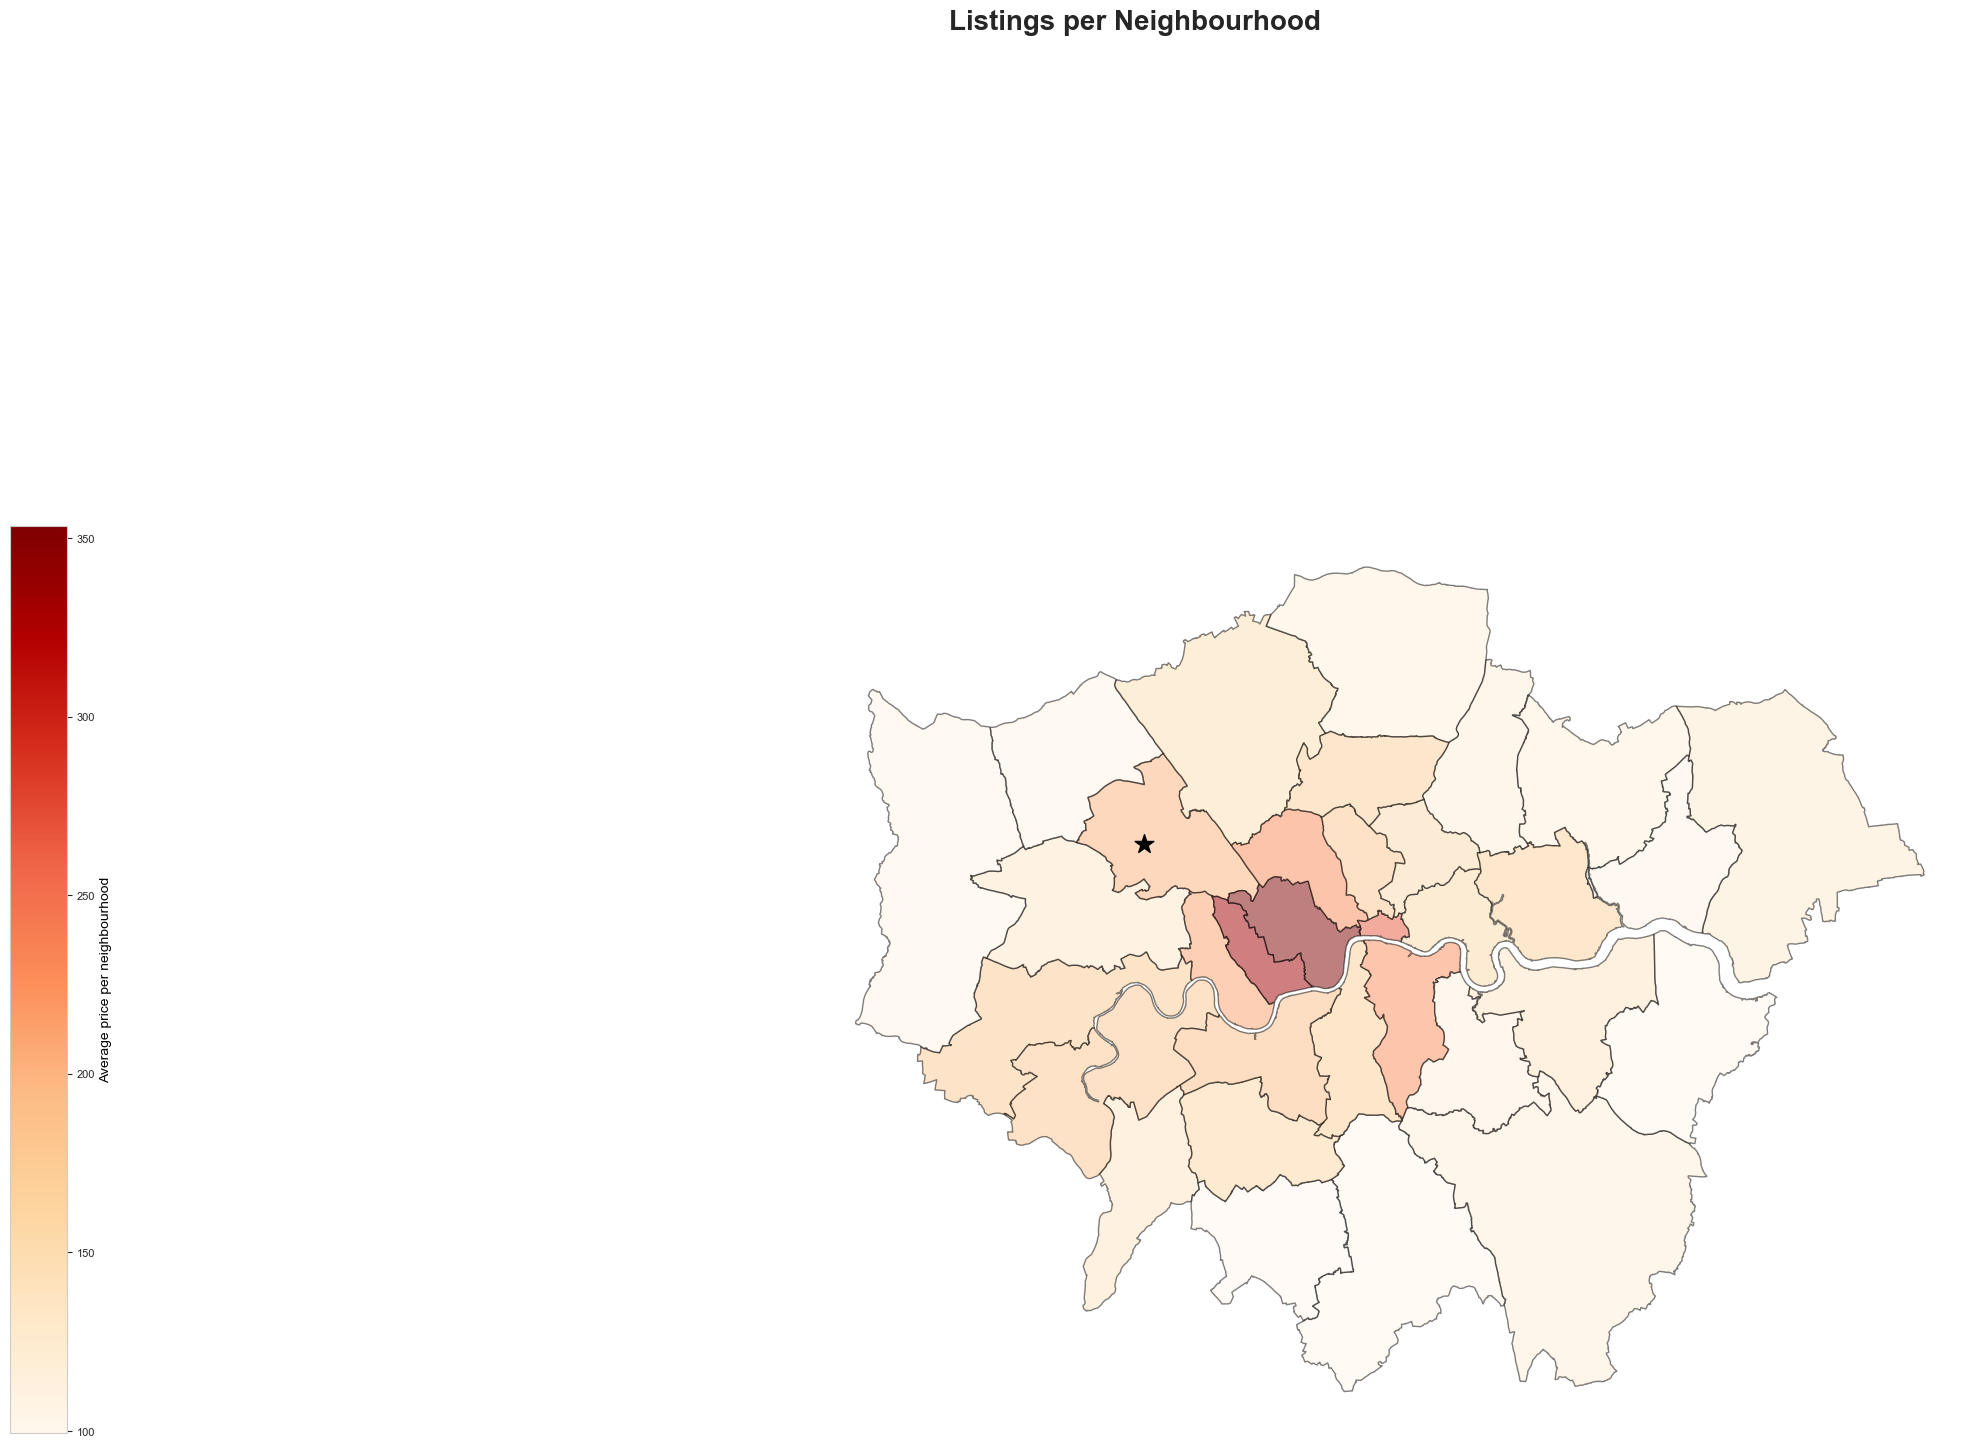

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(30,20))

lgnd_kwds = {'label': 'Average price per neighbourhood', 
             'orientation': 'vertical'}

divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="3%")

base = neighbourhood.plot(ax=ax,
                        column='price_mean', 
                        edgecolor='black',
                        cmap='OrRd', 
                        alpha=0.5,
                        zorder=1,
                        cax=cax,                        
                        legend=True, 
                        legend_kwds=lgnd_kwds)


ts_df.plot(ax = base, markersize = 200, color = 'black', marker = '*')

# ctx.add_basemap(base, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

base.set_axis_off();

plt.suptitle('Listings per Neighbourhood', fontsize=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,15))

lgnd_kwds = {'label': 'Average price per neighbourhood', 
             'orientation': 'vertical'}

lgnd_kwds_2 = {'title': 'Neighborhoods',
               'loc': 'upper left',
               'bbox_to_anchor': (1, 1.03),
               'ncol':1}

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("left", size="3%")

base = neighbourhood.plot(ax=ax,
                        column='price_mean', 
                        edgecolor='black',
                        cmap='Blues', 
                        alpha=0.2,
                        zorder=2)

listings_geo.plot(ax=base, marker='o', markersize=15, column="price_mean", legend=True, cmap='OrRd', scheme="NaturalBreaks", zorder=1)

# ts_df.plot(ax = base, markersize = 50, color = 'black', marker = '*', zorder=3)

# ctx.add_basemap(base, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

base.set_axis_off();

# plt.title('Listings per Neighbourhood')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(30,20))

lgnd_kwds = {'label': 'Average price per neighbourhood', 
             'orientation': 'vertical'}

lgnd_kwds_2 = {'title': 'Neighborhoods',
               'loc': 'upper left',
               'bbox_to_anchor': (1, 1.03),
               'ncol':1}

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("left", size="3%")

base = neighbourhood.plot(ax=ax,
                        column='price_mean', 
                        edgecolor='black',
                        cmap='OrRd', 
                        alpha=0.4,
                        zorder=2)

listings_geo.plot(ax=base, marker='o', markersize=20, column="price_mean", legend=True, cmap='inferno_r', scheme="NaturalBreaks", zorder=1)

ts_df.plot(ax = base, markersize = 400, color = 'black', marker = '*', zorder=3)

# ctx.add_basemap(base, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

base.set_axis_off();

# plt.title('Listings per Neighbourhood')
plt.show()

In [ ]:
import numba

In [ ]:
lgnd_kwds = {'title': 'Neighborhoods',
             'loc': 'upper left',
             'bbox_to_anchor': (1, 1.03),
             'ncol':1}

base=neighbourhood.plot(color='white', edgecolor='black', figsize=(30,20), zorder=2, alpha=0.3)
listings_geo.plot(ax=base, marker='o', markersize=10, column="price_mean", legend=True, cmap='inferno_r', scheme='user_defined', 
                  classification_kwds={'bins':[150, 350, 670, 2000]}, zorder=1)
ts_df.plot(ax = base, markersize = 400, color = 'black', marker = '*', zorder=3)

base.set_axis_off();

plt.title('Listings per Neighbourhood')
plt.show()

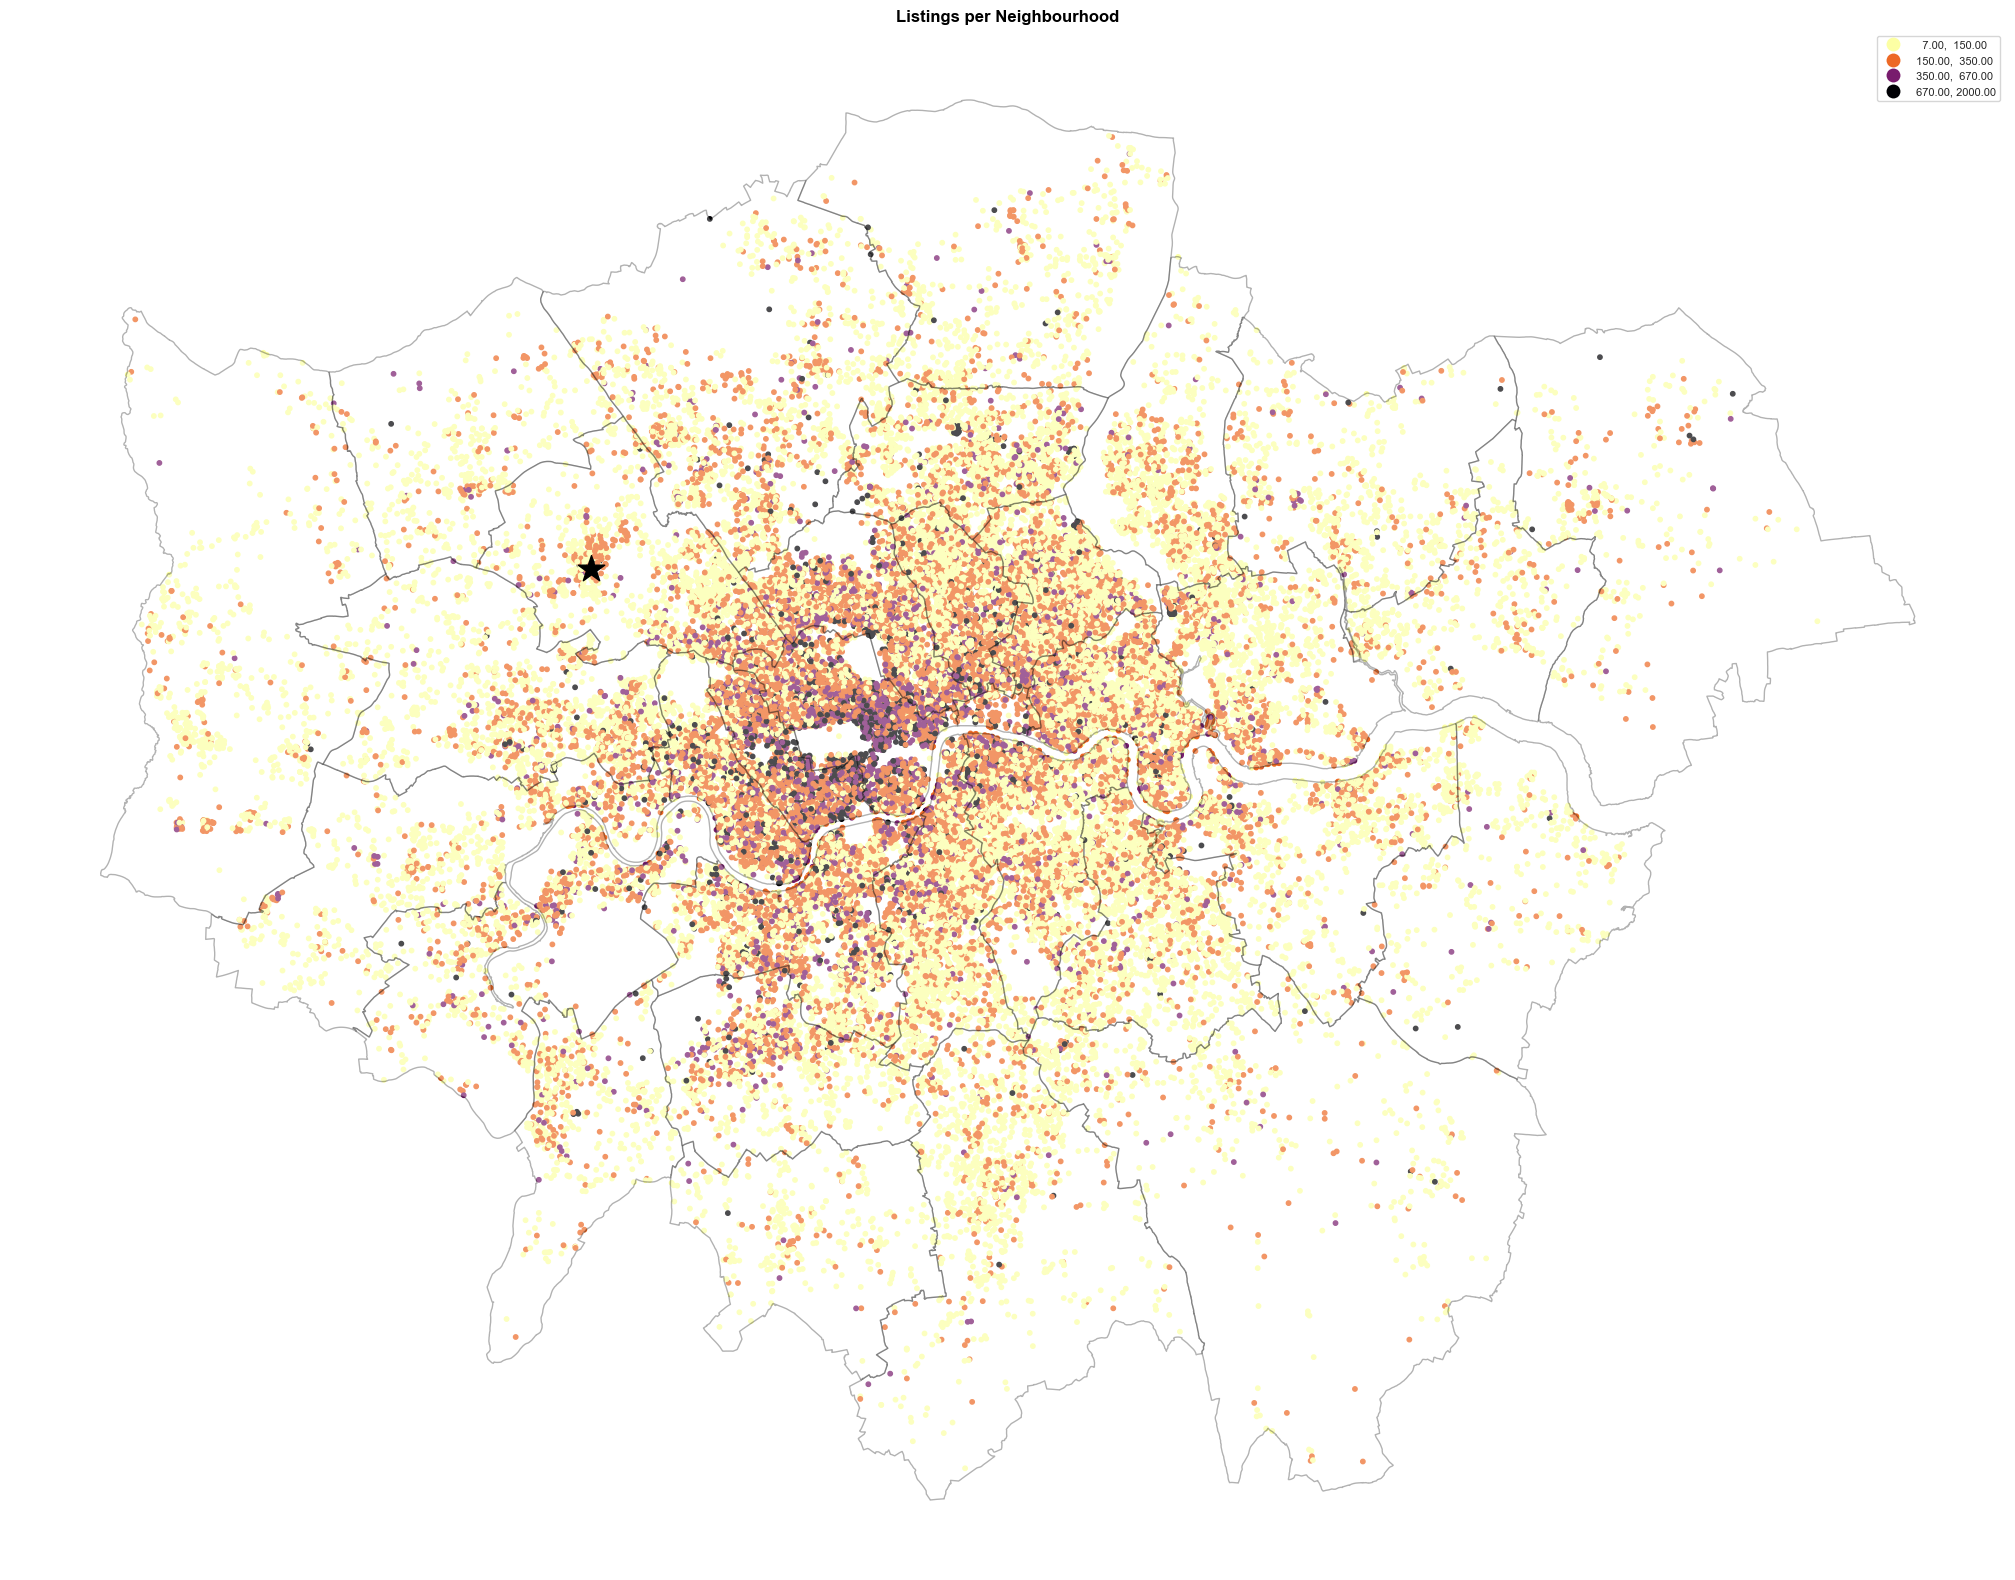

In [62]:
lgnd_kwds = {'title': 'Neighborhoods',
             'loc': 'upper left',
             'bbox_to_anchor': (1, 1.03),
             'ncol':1}

base=neighbourhood.plot(color='white', edgecolor='black', figsize=(30,20), zorder=2, alpha=0.3)
listings_geo.plot(ax=base, marker='o', markersize=10, column="price_mean", legend=True, cmap='inferno_r', scheme='user_defined', 
                  classification_kwds={'bins':[150, 350, 670, 2000]}, zorder=1)
ts_df.plot(ax = base, markersize = 400, color = 'black', marker = '*', zorder=3)

base.set_axis_off();

plt.title('Listings per Neighbourhood')
plt.show()

(base layer)[https://stackoverflow.com/questions/63644131/how-to-use-geopandas-to-plot-latitude-and-longitude-on-a-more-detailed-map-with]